In [10]:
import scipy.stats as stats
import subprocess
import scipy as sp
import rasterio
import numpy as np
import meshio
import pandas as pd
from matplotlib import pyplot as plt
import pyvista
meshC =  pyvista.read(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\gridTetraCoarse.vtu")

In [11]:

dfRiver = pd.read_csv('C:\\Users\\Andrea\\Documents\\Flow\\Optimization\\headData\\averageInTime\\wellHeadRivers2016.csv')
wellLocRiver = dfRiver
wellLocRiver['Bottom'] = wellLocRiver['quota[m]'] - wellLocRiver['depth']

df = pd.read_csv('C:\\Users\\Andrea\\Documents\\Flow\\Optimization\\headData\\averageInTime\\wellHeadPo2016.csv')
wellLoc = df
wellLoc['Bottom'] = wellLoc['quota[m]'] - wellLoc['depth']


weights = np.loadtxt('weights.txt')

nRecostruction = sum(weights[:,1])

In [12]:
#function for determine qms and K. The model calibration is driven by all the head data
def flowSimulationH(P,*args):
    #model parameters
    if len(args) == 1:
        args = args[0]
    
    myfile = open(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\Po1HP.prj", "rt")
    contents = myfile.readlines()
    myfile.close()
    
    wordX = 'permeability' ## it is set according to the uncertainty probability.
    nameOfRivers = ['Adige','Secchia','DoraBaltea','Adda',
                    'Ticino','Chiese','Oglio','Tanaro',
                    'Po1','Po2','Po3','Po4','Reno','none']
    al = 0
    worda = 'alpha' + nameOfRivers[al]
    wordqm = 'qms'
    wordh0 = 'h0'
    j=0
    qms = 0
    h0 = 0
    P0 = h0*9810
    
    # set the K parameters 
    Kappa1 = (10**P[0]*weights[0,:] + 10**P[1]*weights[1,:] + 
              10**P[2]*weights[2,:] + 10**P[3]*weights[3,:] + 
              10**P[4]*weights[4,:] + 10**P[5]*weights[5,:])/nRecostruction
    meshC['Kappa1'] = Kappa1
    meshC.save(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\gridTetraCoarse.vtu")
    for i in range(len(contents)):
        
#         if wordX in contents[i]:
#             value = contents[i+2].split('<value>').pop().split('</value>')[0]
#             if j>0:
#                 K = 10**P[j-1]
#                 value2= str(K)
#                 contents[i+2] = contents[i+2].replace(value, value2)
#                 permName = 'k%1d' % j 
#                 print(permName, value2)
#             j += 1

        #set the alpha values
        if worda in contents[i]:
            if '<value>' in contents[i+2]:
                value = contents[i+2].split('<value>').pop().split('</value>')[0]
                #a = args[0][al]
                a = args[al]
                value2= str(a)
                contents[i+2] = contents[i+2].replace(value, value2)
               # print(worda, value2)
                al += 1
                worda = 'alpha' + nameOfRivers[al]
               
        #set the qms values          
        if wordqm in contents[i]:
              if '<value>' in contents[i+2]:
                    value = contents[i+2].split('<value>').pop().split('</value>')[0]
                    qmsValue2 = P[-1]*float(value)
                    value2= str(qmsValue2)
                    contents[i+2] = contents[i+2].replace(value, value2)                    
                   # print('C_qms', qms+1 ,':', P[-1],';', 'qms', qms+1 , ':' , value2)
                    qms += 1
                    
        if wordh0 in contents[i]:
              if '<value>' in contents[i+2]:
                    value = contents[i+2].split('<value>').pop().split('</value>')[0]
                    value2= str(P0)
                    contents[i+2] = contents[i+2].replace(value, value2)                  
    
    
            
    with open(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\Po2.prj", 'w') as file:
        file.writelines( contents )
    
    
    subprocess.check_call([r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs-6.4.3-16-g9a7564950-Windows-10.0.22000-python-3.10.7-utils\bin\ogs.exe",
                           r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\Po2.prj"])

    mesh = meshio.read(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\Po_ts_1_t_1.000000.vtu")
    data = mesh.points
    sample = np.array([wellLoc.longitude,wellLoc.latitude,wellLoc.Bottom]).T
    kdtree=sp.spatial.KDTree(data)
    dist,points=kdtree.query(sample,1)
    simulatedH = (mesh.point_data['pressure'][points].T)/9810+sample[:,2]
    fobj = (sum(((simulatedH-np.array(wellLoc['head[m]']))**2)**(1/2)))/len(wellLoc['head[m]'])
    print('RMSE: ',fobj)
    return fobj

In [29]:
P = [-1.087589124157963916e+01,    #log_10(k1)
     -8.885058263904584308e+00,    #log_10(k2)
     -1.231777616206400872e+01,    #log_10(k3)
     -1.028203150197779969e+01,    #log_10(k4)
     -16,#-1.105200435381599711e+01,    #log_10(k5)
     -16,#-1.442130128017940471e+01,    #log_10(k6)
     1,                            #C_qms1-29
    ]

args1 = [
     9.438946449848746448e-05,     #alphaAdige
     9.438946449848746448e-05,     #alphaSecchia
     9.438946449848746448e-05,     #alphaDoraBaltea
     9.438946449848746448e-05,     #alphaAdda
     9.438946449848746448e-05,     #alphaTicino
     9.438946449848746448e-05,     #alphaChiese
     9.438946449848746448e-05,     #alphaOglio
     9.438946449848746448e-05,     #alphaTanaro
     9.438946449848746448e-05,     #alphaPo1
     9.438946449848746448e-05,     #alphaPo2
     9.438946449848746448e-05,     #alphaPo3
     9.438946449848746448e-05,     #alphaPo4
     9.438946449848746448e-05,     #alphaReno
    ]





In [30]:
#1run the model with the parameters set in P
print('fobj1:', flowSimulationH(P,args1))

RMSE:  16.063857636199558
fobj1: 16.063857636199558


In [6]:
def flowSimulationR(P,*args):
    #model parameters
    if len(args) == 1:
        args = args[0]
    
    
    myfile = open(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\Po1HP.prj", "rt")
    contents = myfile.readlines()
    myfile.close()
    
    wordX = 'permeability' ## it is set according to the uncertainty probability.
    nameOfRivers = ['Adige','Secchia','DoraBaltea','Adda','Ticino','Chiese','Oglio','Tanaro','Po1','Po2','Po3','Po4','Reno','none']
    al = 0
    worda = 'alpha' + nameOfRivers[al]
    wordqm = 'qms'
    wordh0 = 'h0'
    j=0
    qms = 0
    h0 = 0
    P0 = h0*9810
    
    # set the K parameters 
    Kappa1 = (10**args[0]*weights[0,:] + 10**args[1]*weights[1,:] + 
              10**args[2]*weights[2,:] + 10**args[3]*weights[3,:] + 
              10**args[4]*weights[4,:] + 10**args[5]*weights[5,:])/nRecostruction
    meshC['Kappa1'] = Kappa1
    meshC.save(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\gridTetraCoarse.vtu")
    for i in range(len(contents)):
#         if wordX in contents[i]:
#             value = contents[i+2].split('<value>').pop().split('</value>')[0]
#             if j>0:
#                 K = 10**P[j-1]
#                 value2= str(K)
#                 contents[i+2] = contents[i+2].replace(value, value2)
#                 permName = 'k%1d' % j 
#                 print(permName, value2)
#             j += 1

    
    
    
        #set the alpha values
        if worda in contents[i]:
            if '<value>' in contents[i+2]:
                value = contents[i+2].split('<value>').pop().split('</value>')[0]
                a = P[al]
                value2= str(a)
                contents[i+2] = contents[i+2].replace(value, value2)
                #print(worda, value2)
                al += 1
                worda = 'alpha' + nameOfRivers[al] 
               
        #set the qms values          
        if wordqm in contents[i]:
              if '<value>' in contents[i+2]:
                    value = contents[i+2].split('<value>').pop().split('</value>')[0]
                    qmsValue2 = args[-1]*float(value)
                    value2= str(qmsValue2)
                    contents[i+2] = contents[i+2].replace(value, value2)                    
                    #print('C_qms', qms+1 ,':', args[-1],';', 'qms', qms+1 , ':' , value2)
                    qms += 1
                    
        if wordh0 in contents[i]:
              if '<value>' in contents[i+2]:
                    value = contents[i+2].split('<value>').pop().split('</value>')[0]
                    value2= str(P0)
                    contents[i+2] = contents[i+2].replace(value, value2)                  
    
    
            
    with open(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\Po2.prj", 'w') as file:
        file.writelines( contents )
    
    
    subprocess.check_call([r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs-6.4.3-16-g9a7564950-Windows-10.0.22000-python-3.10.7-utils\bin\ogs.exe", r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\Po2.prj"])

    mesh = meshio.read(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\Po_ts_1_t_1.000000.vtu")
    data = mesh.points
    sample = np.array([wellLocRiver.longitude,wellLocRiver.latitude,wellLocRiver.Bottom]).T
    kdtree=sp.spatial.KDTree(data)
    dist,points=kdtree.query(sample,1)
    simulatedH = (mesh.point_data['pressure'][points].T)/9810+sample[:,2]
    fobj = (sum(((simulatedH-np.array(wellLocRiver['head[m]']))**2)**(1/2)))/len(wellLocRiver['head[m]'])
    print('RMSE: ',fobj)
    return fobj

In [33]:
args2 = [-1.087589124157963916e+01,    #log_10(k1)
     -8.885058263904584308e+00,    #log_10(k2)
     -1.231777616206400872e+01,    #log_10(k3)
     -1.028203150197779969e+01,    #log_10(k4)
     -1.105200435381599711e+01,    #log_10(k5)
     -1.442130128017940471e+01,    #log_10(k6)
     0.5,                            #C_qms1-29
    ]

P = [
     9.438946449848746448e-05,     #alphaAdige
     9.438946449848746448e-05,     #alphaSecchia
     9.438946449848746448e-05,     #alphaDoraBaltea
     9.438946449848746448e-05,     #alphaAdda
     9.438946449848746448e-05,     #alphaTicino
     9.438946449848746448e-05,     #alphaChiese
     9.438946449848746448e-05,     #alphaOglio
     9.438946449848746448e-05,     #alphaTanaro
     9.438946449848746448e-05,     #alphaPo1
     9.438946449848746448e-05,     #alphaPo2
     9.438946449848746448e-05,     #alphaPo3
     9.438946449848746448e-05,     #alphaPo4
     9.438946449848746448e-05,     #alphaReno
    ]



In [34]:
print('fobj2:', flowSimulationR(P,args2))

RMSE:  7.305130898811105
fobj2: 7.305130898811105


fobj: 18.89303335342579


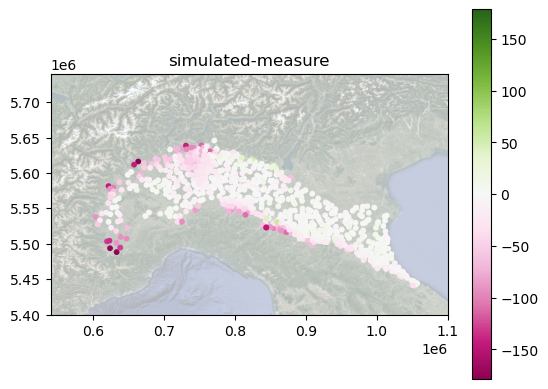

In [35]:
#plot the error  in a map
mesh = meshio.read(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\Po_ts_1_t_1.000000.vtu")
data = mesh.points
sample = np.array([wellLoc.longitude,wellLoc.latitude,wellLoc.Bottom]).T
kdtree=sp.spatial.KDTree(data)
dist,points=kdtree.query(sample,1)
simulatedH = (mesh.point_data['pressure'][points].T)/9810+sample[:,2]

fobj = (sum(((simulatedH-np.array(wellLoc['head[m]']))**2)**(1/2)))/len(wellLoc['head[m]'])
print('fobj:',fobj)
err = simulatedH-np.array(wellLoc['head[m]'])
img = plt.imread(r"C:\Users\Andrea\Documents\Flow\Optimization\background.tif")
img = np.array(img)
img[:,:,3] = img[:,:,3]*0.32
ext = [540000.0000, 1100000.0000,5400000.0000,5740000.0000]
plt.imshow(img, zorder=0, extent=ext)
cBarRange = max(np.abs(min(err)),max(err))
plt.scatter(sample[:,0],sample[:,1],zorder=1, s=10, c=err, cmap='PiYG', vmin=(-cBarRange), vmax=cBarRange)#vmin=min(err), vmax=max(err))
plt.colorbar()
plt.title('simulated-measure')
plt.show()

Average error: -14.997299398586142
error standard deviation: 28.34338359247347


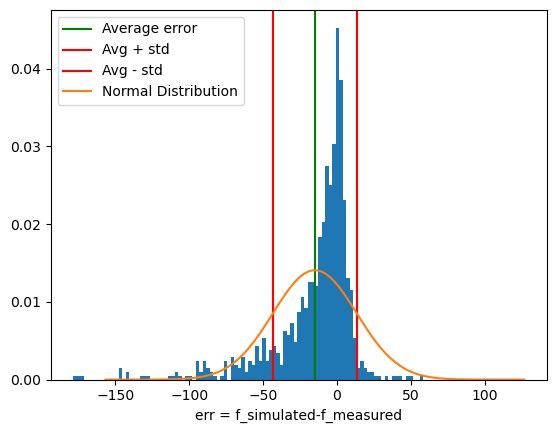

In [36]:
counts, bins = np.histogram(err,bins=100, density=True)
plt.stairs(counts, bins,fill=True)
plt.xlabel('err = f_simulated-f_measured')
plt.axvline(x = np.average(err), color = 'g', label = 'Average error')
plt.axvline(x = np.average(err) + np.std(err), color = 'r', label = 'Avg + std')
plt.axvline(x = np.average(err) - np.std(err), color = 'r', label = 'Avg - std')
mu = np.average(err)
sigma =  np.std(err)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma),label = 'Normal Distribution')
plt.legend()
print('Average error:', mu)
print('error standard deviation:', sigma)


In [ ]:
#define hyperparameters
F=0.5
CR = 0.5
NP = 1
bounds1 = [(-13, -7),            #log_10(k1)
          (-13, -7),           #log_10(k2)
          (-13, -8),           #log_10(k3)
          (-16, -9),           #log_10(k4)
          (-16, -9),           #log_10(k5)
          (-18, -11),          #log_10(k6)
          (0.5, 1.5),              #C_qms1
           ]

bounds2 = [
          (0, 1e-4),        #alphaAdige
          (0, 1e-4),        #alphaSecchia
          (0, 1e-4),        #alphaDoraBaltea
          (0, 1e-4),        #alphaAdda
          (0, 1e-4),        #alphaTicino
          (0, 1e-4),        #alphaChiese
          (0, 1e-4),        #alphaOglio
          (0, 1e-4),        #alphaTanaro
          (0, 1e-4),        #alphaPo1
          (0, 1e-4),        #alphaPo2
          (0, 1e-4),        #alphaPo3
          (0, 1e-4),        #alphaPo4
          (0, 1e-4),        #alphaReno  
           ]
maxIter = 2
tollerance = 1e-4

In [ ]:
result = sp.optimize.symbiotic_differential_evolution(flowSimulationH, flowSimulationR, bounds1, bounds2, args1=args1, args2=args2,
                           strategy='best1bin', maxiter=maxIter, popsize=NP, tol=0.01,
                           mutation=F, recombination=CR, seed=None,
                           callback=None, disp=False, polish=True,
                           init='latinhypercube', atol=0, updating='immediate',
                           workers=1, constraints1=(), constraints2=(), x0=None, 
                           integrality=None, vectorized=False)

print(result)


In [ ]:
from scipy.optimize import symbiotic_differential_evolution

In [ ]:
import scipy.stats as stats
import subprocess
import scipy as sp
import rasterio
import numpy as np
import meshio
import pandas as pd
from matplotlib import pyplot as plt
import pyvista
meshC =  pyvista.read(r"C:\Users\Andrea\Documents\Flow\OpenGeoSys\ogs62016hetPermCopy\gridTetraCoarse.vtu")

In [ ]:
result = sp.optimize.differential_evolution(flowSimulationH, bounds1, args=args1,
                           strategy='best1bin', maxiter=maxIter, popsize=NP, tol=0.01,
                           mutation=F, recombination=CR, seed=None,
                           callback=None, disp=False, polish=True,
                           init='latinhypercube', atol=0, updating='immediate',
                           workers=1, constraints=(), x0=None, 
                           integrality=None, vectorized=False)

print(result)

In [ ]:
args1